# Building Micrograd
In this notebook, we will be learning gradient descent and how to implement it from scratch.

Video Reference: [NEURAL NETWORKS: Zero to Hero - Building Micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Creating simple polynomial function
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
# Testing the function
f(3.0)

In [ ]:
# Now just to visualize the function
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
# Now we will work on derivatives
# Derivative: Definition of derivative is the slope of the tangent line to the curve at a point... Mathematically, it is defined as the limit of the average rate of change of the function as the interval approaches zero. i.e. f'(x) = lim(h->0) [f(x+h) - f(x)] / h
h = 0.000001
x = 3.0
print(f'For x = {x}, f(x) = {f(x)}')
print(f'For x = {x + h}, f(x + h) = {f(x + h)}')

# now for the derivative or slope
slope = (f(x + h) - f(x)) / h
print(f'The slope at x = {x} is approximately {slope}')

# Now at some point the slope will be equal to 0
x = 2/3
slope = (f(x + h) - f(x)) / h
print(f'The slope at x = {x} is approximately {slope}')

In [ ]:
# Now we will try some different equation with many variable and try to get the derivative of that
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

In [ ]:
# Let's start calculating the derivatives
h = 0.0001

# imputs
a = 2.0
b = -3.0
c = 10.0

# now we will derive with respect to a, b and c
d1 = a*b + c
# a += h
# b += h
c += h
d2 = a*b + c
slope = (d2 - d1) / h
print(f'D1: {d1}, D2: {d2}, Slope: {slope}')

In [53]:
class Value:
    
  def __init__(self, data, _children=(), _op='', label = ''):
    """
    Creating Initial Value
    Args:
      data: some numerical value
      grad: gradient of the value (derivative)
      _backward: function to propagate the gradient backward
      _children: a tuple of previous operations
      _op: symbol representing the operation (+, *, etc.)
      label: a string label for the value (name of the variable for visualization)
    """
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)

    out = Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    # Build the topological order
    topo = []
    visited = set()

    def build_topo(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          build_topo(child)
        topo.append(node)

    build_topo(self)

    # Reverse the topological order
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
# This is some copy pasted code that will help visualize the operation chain and it will make sense why are we storing the previous values and operations.

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

# HOW TO USE
# You can use the draw_dot function to visualize the computation graph of a Value object.
# Simply call draw_dot(d) where d is the Value object you want to visualize.


In [ ]:
draw_dot(L)

In [ ]:
def lol():
  
  h = 0.0001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data + h

  # printing the derivatives
  print("L1:", L1)
  print("L2:", L2)
  print("Slope:", (L2 - L1) / h)

lol()

In [ ]:
# manual back propagation

# Let's calculate gradients
# dL/dL = 1.0
L.grad = 1.0

# dL/dd = f, dL/df = d
d.grad = L.grad * f.data
f.grad = L.grad * d.data

# dL/de = dL/dd * dd/de = f * 1 = f
e.grad = d.grad * 1.0

# dL/dc = dL/dd * dd/dc = f * 1 = f
c.grad = d.grad * 1.0

# dL/db = dL/de * de/db = f * a
b.grad = e.grad * a.data

# dL/da = dL/de * de/da = f * b
a.grad = e.grad * b.data

In [ ]:
# manual forward pass is by nudging the inputs by a small amount of gradient we reduce the loss

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# lets calculate the loss again
e = a * b
d = e + c
L = d * f

print(L.data)

---
Let do one more manual back propogation with a bit more complex equation which will look like a neural network layer

In [45]:
# Following is an equation for a simple neuron with two inputs
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# apply the tanh activation function
o = n.tanh(); o.label = 'o'

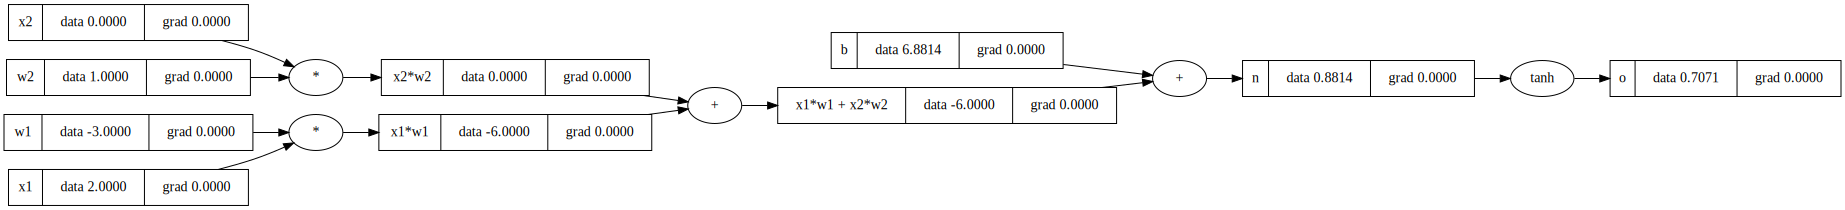

In [46]:
draw_dot(o)

In [23]:
# manual backpropagation

# do/do = 1.0
o.grad = 1.0

# eq: o = tanh(n)
# do/dn = d(tanh(n))/dn = 1 - tanh(n)^2 = 1 - o.data^2
n.grad = o.grad * (1 - o.data ** 2) # n.grad =  0.5

# eq: n = x1w1x2w2 + b
# dn/d(x1w1x2w2) = 1
# do/d(x1w1x2w2) = do/dn * dn/d(x1w1x2w2) = do/dn
x1w1x2w2.grad = n.grad * 1.0 # x1w1x2w2.grad = 0.5
# dn/db = 1
# do/db = do/dn * dn/db = do/dn
b.grad = n.grad * 1.0 # b.grad = 0.5

# eq: x1w1x2w2 = x1w1 + x2w2
# dx1w1x2w2/dx1w1 = 1
# do/dx1w1 = do/d(x1w1x2w2) * d(x1w1x2w2)/dx1w1 = do/dn
x1w1.grad = x1w1x2w2.grad * 1.0 # x1w1.grad = 0.5
# dx1w1x2w2/dx2w2 = 1
# do/dx2w2 = do/d(x1w1x2w2) * d(x1w1x2w2)/dx2w2 = do/dn
x2w2.grad = x1w1x2w2.grad * 1.0 # x2w2.grad = 0.5

# eq: x1w1 = x1*w1
# dx1w1/dx1 = w1
# do/dx1 = do/d(x1w1) * dx1w1/dx1 = do/dn * w1
x1.grad = x1w1.grad * w1.data # x1.grad = -1.5
# dx1w1/dw1 = x1
# do/dw1 = do/d(x1w1) * dx1w1/dw1 = do/dn * x1
w1.grad = x1w1.grad * x1.data # w1.grad = 1.0

# eq: x2w2 = x2*w2
# dx2w2/dx2 = w2
# do/dx2 = do/d(x2w2) * dx2w2/dx2 = do/dn * w2
x2.grad = x2w2.grad * w2.data # x2.grad = 0.5
# dx2w2/dw2 = x2
# do/dw2 = do/d(x2w2) * dx2w2/dw2 = do/dn * x2
w2.grad = x2w2.grad * x2.data # w2.grad = 0.0


In [27]:
# Now lets do the backprogation using the _backward function
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [40]:
# Now since we don't want to do this manually, let's do a topological sort of the graph to determine the order of operations.

topo = []          # stores nodes in topological order
visited = set()    # tracks visited nodes

def build_topo(v):
  if v not in visited:
    visited.add(v)         # mark node as visited
    for child in v._prev:  # recursively visit dependencies
      build_topo(child)
    topo.append(v)         # add node AFTER its children

build_topo(o)              # start from output node 'o'
topo                       # now contains nodes in order


[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

### Understanding `build_topo`

The goal of backpropagation is to traverse the computation graph in reverse, so that
gradients flow from the output node back to the inputs.

To do this, we use **topological sorting**:
- Visit each node’s dependencies (children) first.
- Add the node itself after all its children have been added. (that means if x = a + b, we add a and b in `topo` after that we add x)
- This ensures inputs come before outputs.

The result is a list (`topo`) of nodes in the correct order for backprop.
When we reverse this list, we can propagate gradients correctly.

Example for our neuron:
```
# Inputs
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = tanh(n)

# graph
x1 ─┐
    * → x1w1 ─┐
w1 ─┘          \
                + → x1w1x2w2 ─┐
x2 ─┐           /              \
    * → x2w2 ──┘                + → n → tanh → o
w2 ─┘                           /
                               b


# Topological order
topo = [x1, w1, x1w1, x2, w2, x2w2, x1w1x2w2, b, n, o]
```

`topo` will store them in this order, children before parents.


Topological order: ['w2', 'x2', 'x2*w2', 'x1', 'w1', 'x1*w1', 'x1*w1 + x2*w2', 'b', 'n', 'o']


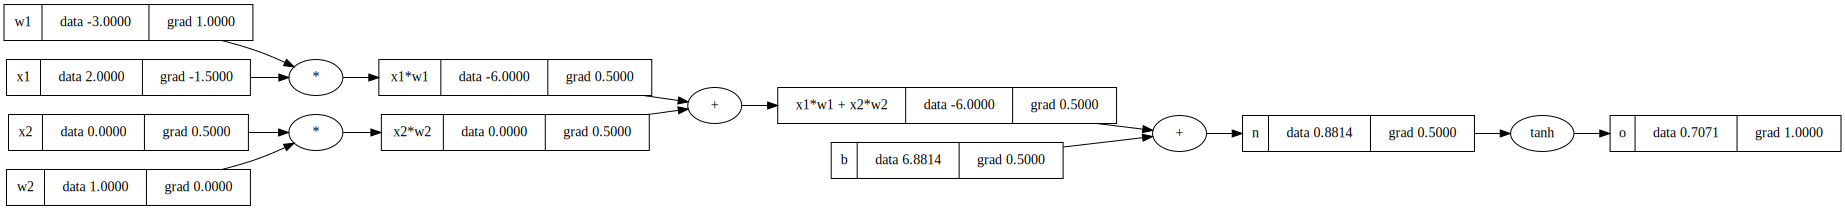

In [ ]:
# now to do the backpropagation in order we will first run the build_topo cell. Then do the backward pass on the reversed topo list.

o.grad = 1.0 # this is important to set so all our values have a gradient
print(f"Topological order: {[name.label for name in topo]}")
for node in reversed(topo):
    node._backward()

draw_dot(o)

# now since we don't want to do this again and again of calculating the topological order, and then doing reverse and then doing _backward on it. We will create a function in Value class.

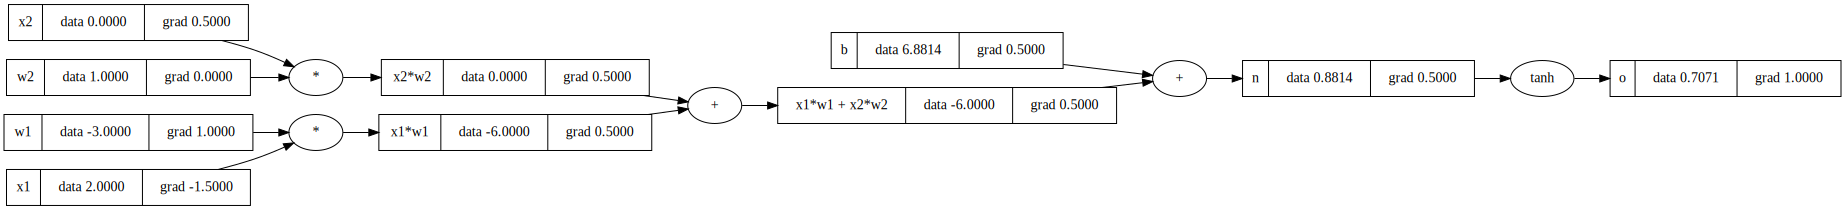

In [47]:
# So now we can do directly a backward pass like this
o.backward()

draw_dot(o)

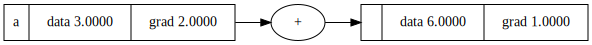

In [51]:
# few more examples
a = Value(3.0, label='a')
b = a + a
b.backward()
draw_dot(b)

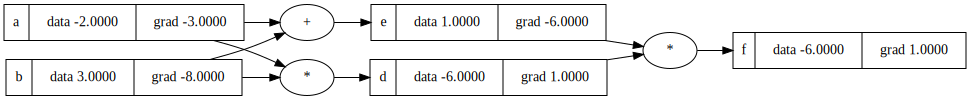

In [52]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)